In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

from sklearn.metrics import confusion_matrix

import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential


from  tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize

from sklearn.utils import resample



Toutes les constantes sont initiés ici.

In [ ]:
SIZE = 32
n_samples = 500
num_classes = 7
batch_size = 16
epochs = 50
path = r'C:\Users\DELL\Desktop\IRM\BDM PROJET\DATA'


Importation de la base de données.

In [2]:
# On utiliseras le fichier HAM10000_metadata, la lecture des images se fera donc manuellement.
skin_df = pd.read_csv(path+'\HAM10000_metadata.csv')

# Affichage des classes disponibles
le = LabelEncoder()
le.fit(skin_df['dx'])
skin_df['label'] = le.transform(skin_df["dx"])

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


À ce stade, on aperçois que la base de données est mal répartie, ainsi, on essaie de balancer les classes :

In [ ]:
df = [skin_df[skin_df['label'] == i] for i in range(num_classes)]
df_balanced = [resample(i, replace=True, n_samples, random_state=42) for i in df]

# Puis on rassemble le tout
skin_df_balanced = pd.concat(df_balanced)

Une fois la data est bien balancée, il est temps d'importer les images dans notre variable

In [7]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join(path, '*', '*.jpg'))}

# On rajoute une colonne path pour stocker les paths des images
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)

# On rajoute une colonne image pour stocker les pixels des images après redimensionnement
skin_df_balanced['image'] = skin_df_balanced['path'].map(
    lambda x: np.asarray(
        Image.open(x).resize((SIZE, SIZE))
    )
)


In [9]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [10]:
#Define the model.
#I've used autokeras to find out the best model for this problem.
#You can also load pretrained networks such as mobilenet or VGG16


model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))

model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))

model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))

model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 128)         0

In [24]:
# Train
#You can also use generator to use augmentation during training.


history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])


#plot the training and validation accuracy and loss at each epoch



Epoch 1/50
165/165 - 28s - loss: 1.5610 - acc: 0.3589 - val_loss: 1.5314 - val_acc: 0.3577 - 28s/epoch - 171ms/step
Epoch 2/50
165/165 - 28s - loss: 1.4891 - acc: 0.3768 - val_loss: 1.4520 - val_acc: 0.3874 - 28s/epoch - 170ms/step
Epoch 3/50
165/165 - 29s - loss: 1.4447 - acc: 0.4057 - val_loss: 1.4189 - val_acc: 0.4091 - 29s/epoch - 174ms/step
Epoch 4/50
165/165 - 29s - loss: 1.3768 - acc: 0.4430 - val_loss: 1.3727 - val_acc: 0.4514 - 29s/epoch - 177ms/step
Epoch 5/50
165/165 - 28s - loss: 1.3646 - acc: 0.4510 - val_loss: 1.3263 - val_acc: 0.4457 - 28s/epoch - 171ms/step
Epoch 6/50
165/165 - 29s - loss: 1.3362 - acc: 0.4747 - val_loss: 1.2443 - val_acc: 0.4926 - 29s/epoch - 178ms/step
Epoch 7/50
165/165 - 28s - loss: 1.2886 - acc: 0.4811 - val_loss: 1.2149 - val_acc: 0.5120 - 28s/epoch - 172ms/step
Epoch 8/50
165/165 - 30s - loss: 1.2741 - acc: 0.4968 - val_loss: 1.2597 - val_acc: 0.5143 - 30s/epoch - 180ms/step
Epoch 9/50
165/165 - 29s - loss: 1.2636 - acc: 0.5067 - val_loss: 1.2056

In [25]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 


<AxesSubplot:>

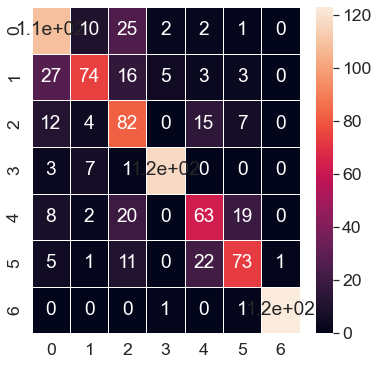

In [26]:
#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)


akiec 0.7315436241610739
bcc 0.578125
bkl 0.6833333333333333
df 0.9140625
mel 0.5625
nv 0.6460176991150443
vasc 0.984


Text(0, 0.5, 'Fraction of  predictions')

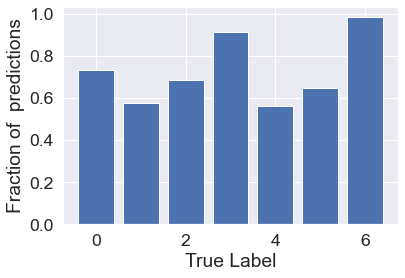

In [27]:


#PLot fractional incorrect misclassifications
incorr_fraction = np.diag(cm) / np.sum(cm, axis=1)
for i in range(7) :
    print(le.classes_[i] , incorr_fraction[i] )
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of  predictions')

In [28]:
path_image=r'cancer type/Test/squamous cell carcinoma/ISIC_0011726.jpg'
new_image=plt.imread(path_image)

In [29]:
from skimage.transform import resize
img=resize(new_image,(32,32,3))

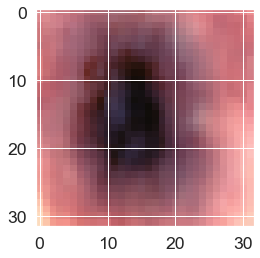

In [30]:
plt.imshow(img)

In [31]:
prediction=model.predict(np.array([img]))

In [32]:
list_index=[0,1,2,3,4,5,6]
x=prediction
for i in range(7):
    for j in range(7):
        if x[0][list_index[i]] > x[0][list_index[j]] :
            temp=list_index[i]
            list_index[i]=list_index[j]
            list_index[j]=temp
print(list_index)

[6, 5, 4, 2, 0, 1, 3]


In [20]:
print(incorr_fraction)

[1.         0.2421875  0.81666667 1.         0.625      0.7079646
 0.2       ]


In [21]:
classification=le.classes_

In [22]:
for i in range(7):
    print([classification[list_index[i]]])

['vasc']
['mel']
['nv']
['bkl']
['akiec']
['bcc']
['df']
